## Example Experiment ##
### Dataset: Labeled Faces in the Wild ###
### Experiment: Two party training for gender classification ###

In [1]:
import cl_simulator.server as server
import cl_simulator.workerclass as worker
import cl_simulator.workerhandler as wh
import cl_simulator.topology_utils as tu

from collections import OrderedDict
import pandas as pd
import numpy as np
import copy
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sattvik/envs/pytorch_env/lib/py

## Parameters ##

In [2]:
epochs = 20
# epochs = 2
batch_size = 64
learning_rate = 0.001
server_learning_rate = 0.05
num_workers = 2
local_iterations = 2

data_path = '../data/lfw/data/'

# default `log_dir` is "runs" - we'll be more specific here
!rm -rf ./runs/experiment_2
writer = SummaryWriter('runs/experiment_2')

## Divide Data between workers ##

In [3]:
attributes_df = pd.read_csv(data_path+'lfw_attributes.txt')

all_names = attributes_df.person.unique()
tt_msk = np.random.rand(len(all_names)) < 0.8
temp_train_names = all_names[tt_msk]
test_names = all_names[~tt_msk]
del all_names, tt_msk
train_val_df = attributes_df.loc[attributes_df['person'].isin(temp_train_names)]
test_df = attributes_df.loc[attributes_df['person'].isin(test_names)]

# add column to indicate split
train_val_df['target'] = 0
# allocate half the people to the target
names = train_val_df['person'].drop_duplicates()
target_worker_names = names.sample(frac=1)[:int(len(names)/2)]
target_worker_names = target_worker_names.reset_index(drop=True)

# populate target field
for index, row in train_val_df.iterrows():
    if row['person'] in target_worker_names.values:
        train_val_df['target'][index] = 1

# print distribution of data
print("entries with worker 1: {}, entries with worker 2: {}, entries in training set: {}, total entries: {}".format(sum(train_val_df['target']==1), sum(train_val_df['target']==0), len(test_df), len(attributes_df)))

/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/sattvik/envs/pytorch_env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3326: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

entries with worker 1: 5555, entries with worker 2: 5046, entries in training set: 2542, total entries: 13143


## Define dataset class ##

In [4]:
class LFWDataset(Dataset):
    """LFW dataset."""

    def __init__(self, data_path, attributes_df, transform=None):
        self.attributes_df = attributes_df
        self.data_path = data_path
        self.transform = transform

    def __len__(self):
        return len(self.attributes_df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, "lfw_home/lfw_funneled", self.attributes_df.iloc[idx]['person'].replace(' ', '_'),"{}_{:04d}.jpg".format(self.attributes_df.iloc[idx]['person'].replace(' ', '_'),self.attributes_df.iloc[idx]['imagenum']))
#         img = torch.from_numpy(cv2.imread(img_path))
        img = Image.open(img_path, mode='r')
        
        label = self.attributes_df.iloc[idx]['Male']>0
        
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.float)

## Define Model ##

In [5]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5)
        self.pool1 = nn.MaxPool2d(4,4)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.pool2 = nn.MaxPool2d(4,4)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.pool3 = nn.MaxPool2d(2,2)
#         self.conv4 = nn.Conv2d(32, 32, 5)
        self.fc1 = nn.Linear(800, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout_layer1 = nn.Dropout(p=0.6)
        self.dropout_layer2 = nn.Dropout(p=0.5)
#         self.dropout_layer3 = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
#         x = F.relu(self.conv4(x))
        x = x.view(x.shape[0],-1)
        x = self.dropout_layer1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout_layer2(x)
#         x = self.dropout_layer3(x)
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

def define_model():
    return ResNet()

## Training, Validation, and Evaluation functions ##

In [6]:
def perform_evaluation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("testing loss: {} and testing accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [7]:
def perform_validation(val_model, dataloader):
    with torch.no_grad():
        epoch_loss = 0
        epoch_accuracy = 0
        for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
            # move data batch to GPU
            data = data.cuda()
            target = target.cuda()
            # forward pass
            output = val_model(data)
#             print(output, target.unsqueeze(1))
            loss = F.binary_cross_entropy(output, target.unsqueeze(1))
            # compute average loss an accuracy
            output = output.to('cpu')
            target = target.to('cpu')
            current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
            epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
            epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
    print("val loss: {} and val accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy

In [8]:
def perform_training(train_model, dataloader, optimizer, local_iters):
    epoch_loss = 0
    epoch_accuracy = 0
    for batch_idx, (data, target) in tqdm_notebook(enumerate(dataloader), total=len(dataloader)):
        # move data batch to GPU
        data = data.cuda()
        target = target.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward pass
        output = train_model(data)
        loss = F.binary_cross_entropy(output, target.unsqueeze(1))
        # backward pass
        loss.backward()
        optimizer.step()
        # compute average loss an accuracy
        output = output.to('cpu')
        target = target.to('cpu')
        current_acc = torch.tensor(((output>0.5)== torch.tensor(target.unsqueeze(1), dtype=torch.bool)).sum(), dtype=torch.float)/torch.tensor(len(target), dtype=torch.float)
        epoch_loss = ((epoch_loss*batch_idx) + loss.item())/(batch_idx+1)
        epoch_accuracy = ((epoch_accuracy*batch_idx) + current_acc.item())/(batch_idx+1)
        if batch_idx%local_iters:
            yield epoch_loss, epoch_accuracy, False
    print("train loss: {} and train accuracy: {}".format(epoch_loss, epoch_accuracy))
    return epoch_loss, epoch_accuracy, True

## Declare genuine worker ##

In [9]:
class target_worker(worker.base_workerclass):
    def __init__(self, name, attributes_df, model):
        super().__init__(name, False)
        self.worker_attributes_df = attributes_df[attributes_df['target']==1]
        print("initializing genuine worker node with ",len(self.worker_attributes_df)," data points")
        self.model = model
        self.local_iters = local_iterations
        # train val split
        all_names = self.worker_attributes_df.person.unique()
        tt_msk = np.random.rand(len(all_names)) < 0.8
        train_names = all_names[tt_msk]
        val_names = all_names[~tt_msk]
        del all_names, tt_msk
        
        # set optimizer
        self.set_optim()
        # create train val and test dataframes
        train_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(train_names)]
        val_df = self.worker_attributes_df.loc[self.worker_attributes_df['person'].isin(val_names)]
        
        train_dataset = LFWDataset(data_path, train_df, transform=transforms.Compose([
#                                                     transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
        val_dataset = LFWDataset(data_path, val_df, transform=transforms.Compose([
#                                                             transforms.RandomResizedCrop(224),
                                                            transforms.RandomHorizontalFlip(),
                                                            transforms.ToTensor()]))
        del train_df, val_df
        
        self.train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        print(len(self.train_dataloader), len(self.val_dataloader))
    
    def set_param(self, w):
        self.model.load_state_dict(w)
    
    def get_params(self):
        return self.model.state_dict()
    
    def set_optim(self):
        self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
    def client_update(self, global_epoch):
        global writer
        self.model = self.model.cuda()
        prev_w = copy.deepcopy(self.model.state_dict())
        # unfreeze layers
#         if 5 == global_epoch:
#             self.model.unfreeze_layer3()
#         if 20 == global_epoch:
#             self.model.unfreeze_layer2()
#         if 50 == global_epoch:
#             self.model.unfreeze_layer1()
#         for epoch in range(self.local_iters):
            # run train and val epochs
#             print("sub-epoch: {}".format(epoch))
        self.model.train()
        train_loss, train_acc, run_val = perform_training(self.model, self.train_dataloader, self.optim, self.local_iters)
        writer.add_scalar('training loss_'+self.name, train_loss, (global_epoch*self.local_iters)+epoch)
        writer.add_scalar('training accuracy_'+self.name, train_acc, (global_epoch*self.local_iters)+epoch)
        self.model.eval()
        if run_val:
            val_loss, val_acc = perform_validation(self.model, self.val_dataloader)
            writer.add_scalar('validation loss_'+self.name, val_loss, (global_epoch*self.local_iters)+epoch)
            writer.add_scalar('validation accuracy_'+self.name, val_acc, (global_epoch*self.local_iters)+epoch)
        graddif = OrderedDict()
        for (item1, item2) in zip(self.model.state_dict().items(),prev_w.items()):
            key1=item1[0]
            value1=item1[1]
            key2=item2[0]
            value2=item2[1]
            diffval = value1-value2
            graddif.update({key1:diffval.cpu()})
        self.model = self.model.cpu()
        return graddif

## Declare malicious worker ##

In [10]:
# class malicious_worker(worker.base_workerclass):
#     def __init__(self, attributes_df, model):
#         super().__init__(True)
#         self.worker_attributes_df = attributes_df[attributes_df['target']==0]
#         print("initializing malicious worker node with ",len(self.worker_attributes_df)," data points")
#         self.model = model
#         self.local_iters = 5
    
#     def set_param(self, w):
#         self.model.load_state_dict(w)
    
#     def set_optim(self):
#         self.optim = optim.Adam(self.model.parameters(), lr=learning_rate)
    
#     def client_update(self):
#         print('ss')

## Initialize components of our simulations ##

In [11]:
server1 = server.server(server_learning_rate)
workers = wh.workerhandler([target_worker("w1", train_val_df,define_model()),target_worker("w2", train_val_df,define_model())])

initializing genuine worker node with  5555  data points
70 18
initializing genuine worker node with  5555  data points
63 24


In [12]:
tm = tu.topology_manager()

## Define network topology ##

In [13]:
tm.connect_star(server1, workers.get_all_workers())

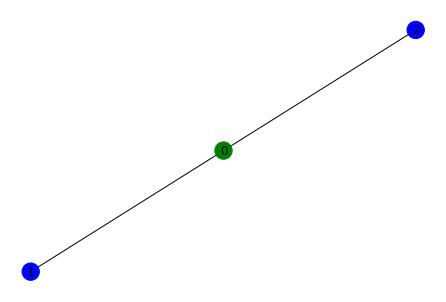

In [14]:
plot = tm.plot_topology()

## Start Training ##

In [15]:
# initialize server weights as model average
server1.set_init_weights(workers.get_average_weights())

# start training
for epoch in range(epochs):
    print("Epoch: ", epoch)
    new_grad = workers.perform_updates(epoch)
    new_w = server1.aggregate(new_grad)
    workers.set_param(new_w)

Epoch:  0
training on worker:  w1


RuntimeError: cuda runtime error (30) : unknown error at /pytorch/aten/src/THC/THCGeneral.cpp:50

## Evaluate Model ##

In [ ]:
# evaluate final model
eval_model = define_model()
eval_model.load_state_dict(new_w)
eval_model.eval()
eval_model = eval_model.cuda()
torch.save(eval_model.state_dict(), "models/experiment2_model.pt")

test_dataset = LFWDataset(data_path, test_df, transform=transforms.Compose([
#                                                     transforms.RandomResizedCrop(224),
                                                    transforms.RandomHorizontalFlip(),
                                                    transforms.ToTensor()
                                                    ]))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loss, test_acc = perform_evaluation(eval_model, test_dataloader)